In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from os import makedirs, path, pardir, listdir
import sys
import copy
import pickle
from datetime import datetime
import json
import cv2
from google.colab.patches import cv2_imshow
import urllib.request
from IPython.display import clear_output

In [2]:
!nvidia-smi
# Hardware requirements for vision zero-shot segmentation
# Using the T4 GPU on the Colab platform is sufficient to assist with data labeling.

Fri May 23 15:01:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


# Example image_url

In [90]:
# Can be freely replaced with example images
image_url = "https://images.pexels.com/photos/3593922/pexels-photo-3593922.jpeg"

In [91]:
import requests
response = requests.get(image_url)

# Check if download was successful
if response.status_code == 200:
    # Write image content to file
    with open("downloaded_image.jpeg", "wb") as f:
        f.write(response.content)
    print("Image downloaded successfully!")
else:
    print("Image download failed. Status code:", response.status_code)

Image downloaded successfully!


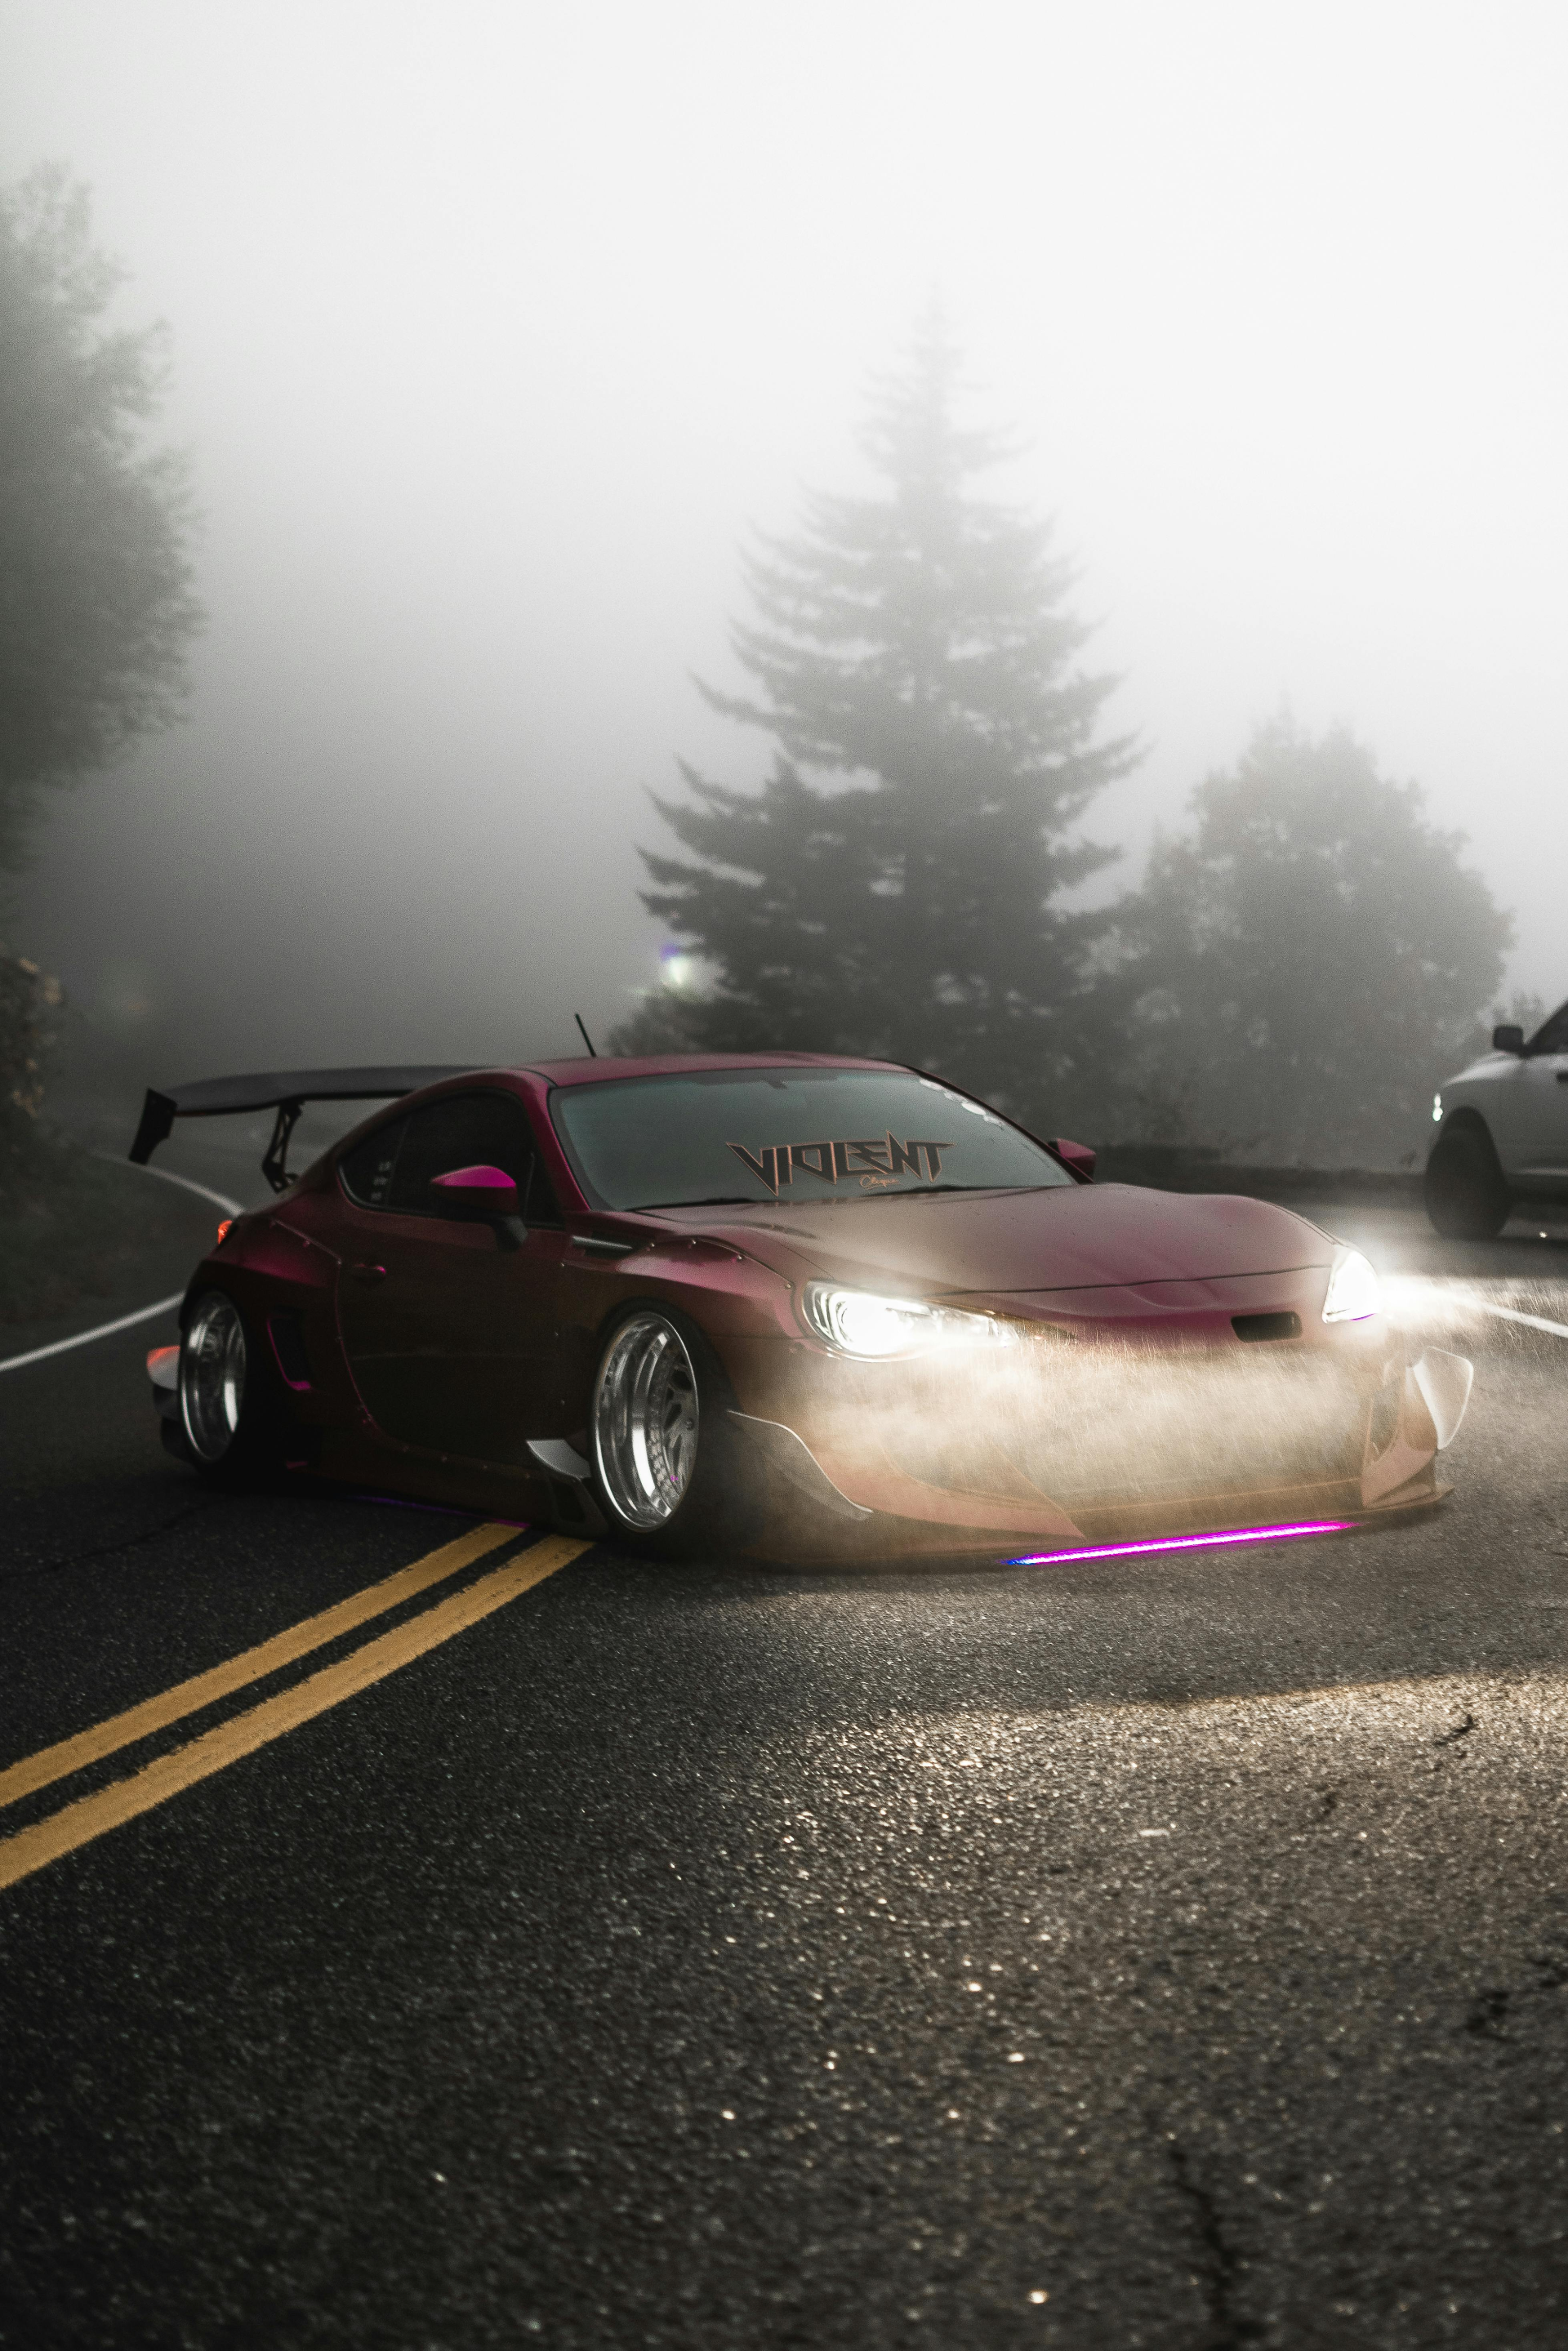

In [92]:
imgPath = r"/content/downloaded_image.jpeg"
target_width = 1920

image = cv2.imread(imgPath)
original_height, original_width = image.shape[:2]
aspect_ratio = original_width / original_height
target_height = int(target_width / aspect_ratio)
resized_image = cv2.resize(image, (target_width, target_height))

from google.colab.patches import cv2_imshow
cv2_imshow(resized_image)
cv2.imwrite('image_width_1920.jpg', resized_image)
imgPath = r"/content/image_width_1920.jpg"

# AI Model parameter

In [58]:
area_threshold_min = 10 #0.5
area_threshold_max = 100 #15

In [61]:
CLIP_device = "cuda" if torch.cuda.is_available() else "cpu"
SAM_device =  "cuda" if torch.cuda.is_available() else "cpu"

In [60]:
# # [segment_anything]
# !pip install segment-anything
# from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [13]:
using_colab = True

In [62]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-ofg6cqz5
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-ofg6cqz5
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [63]:
# sam_model_type = "vit_l"
# sam_filename = "sam_vit_l_8a9f7a.pth"
# sam_model_type = "vit_h"
# sam_filename = "sam_vit_h_4b8939.pth"
# sam_model_type = "vit_h"
# sam_filename = "sam_vit_h_4b8939.pth"
# sam_checkpoint = sam_filename

# sam_filename = "sam2.1_hiera_tiny.pt"
# sam_filename = "sam2.1_hiera_small.pt"
# sam_filename = "sam2.1_hiera_base_plus.pt"
# sam_filename = "sam2.1_hiera_large.pt"

sam_filename = "sam2.1_hiera_large.pt"
url = f"https://dl.fbaipublicfiles.com/segment_anything_2/092824/{sam_filename}"
if not os.path.isfile(sam_filename):
    urllib.request.urlretrieve(url, sam_filename)

sam2_checkpoint = sam_filename
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
sam2 = build_sam2(model_cfg, sam2_checkpoint, device=SAM_device, apply_postprocessing=False)

In [64]:
# Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
# * `segmentation` : the mask
# * `area` : the area of the mask in pixels
# * `bbox` : the boundary box of the mask in XYWH format
# * `predicted_iou` : the model's own prediction for the quality of the mask
# * `point_coords` : the sampled input point that generated this mask
# * `stability_score` : an additional measure of mask quality
# * `crop_box` : the crop of the image used to generate this mask in XYWH format
# mask_generator = SamAutomaticMaskGenerator(sam)
# masks = mask_generator.generate(image)
# print(len(masks))
# # print(masks[0].keys())

# ## Automatic mask generation options
# There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=32,
    pred_iou_thresh=0.8,
    stability_score_thresh=0.9,
    crop_n_layers=2,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=1000,  # Requires open-cv to run post-processing
)

In [65]:
# [CLIP]
!pip install git+https://github.com/openai/CLIP.git
import clip

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-5m6_kyyd
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-5m6_kyyd
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [66]:
# [CLIP]
model, preprocess = clip.load('RN50x4', device=CLIP_device)
# CLIP-ViT-B/32: 400 million parameters
# CLIP-ViT-B/16: 400 million parameters
# CLIP-RN50: 400 million parameters
# CLIP-RN101: 500 million parameters
# CLIP-RN50x4: 1.6 billion parameters

In [37]:
def GetFileNameWithoutExtension(filename):
    file_name = path.basename(filename)
    file_name, file_extension = path.splitext(file_name)
    return file_name

In [81]:
def save_white_image(filename, white_image):
    # Construct the file path for saving
    file_path = os.path.join(filename)
    # Save the image to the specified directory
    save_image = cv2.cvtColor(white_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(file_path, save_image)
    # white_image.save(file_path)

# AI Model predict

In [89]:
# [Define a list of text labels for CLIP to use for matching]
# Users can input their believed correct labels here.
# The CLIP model will then compare the image against these text labels
# to find the most similar match.
labels_list = [
    'Tree',
    'Car',
    'people',
    'tire'
]

In [75]:
def CLIP_predict(image, target=None):
  status = False
  result_dict = {}

  # 對影像進行預處理
  image_Pil = Image.fromarray(image)  #NumPy 轉為 PIL圖像對象
  image_input = preprocess(image_Pil).unsqueeze(0).to(CLIP_device)

  # 運行模型
  with torch.no_grad():
      image_features = model.encode_image(image_input)

  # class_labels
  class_labels = labels_list


  # 載入類別描述
  class_descriptions = clip.tokenize(class_labels).to(CLIP_device)

  # 計算影像與類別描述之間的相似度
  logits_per_image, logits_per_text = model(image_input, class_descriptions)
  probas = logits_per_image.softmax(dim=-1)
  sorted_indices = probas.argsort(descending=True)

  # 輸出預測結果
  first_iteration = True
  for i in sorted_indices[0]:
    class_label = class_labels[i]
    prob = round(float(probas[0][i]), 5)
    print(f"{class_label}: {prob}")

    if first_iteration:
      result_dict["class_label"] = class_label
      result_dict["prob"] = prob
      first_iteration = False

    if target != None:
      if (class_label == target) and (prob >=0.7):
        print(f"****************************")
        status = True

  return status, result_dict


In [99]:
from IPython.display import clear_output

def show_anns_white(anns, image, threshold_min, threshold_max, file_name, output_dir_name):
  print("anns:", len(anns))
  if len(anns) == 0:
    return

  #Full image
  status, result_dict = CLIP_predict(image)
  full_class_label = result_dict["class_label"]
  full_prob = result_dict["prob"]
  result_str = f"{full_class_label}_{full_prob:.4f}"

  #partial image
  current_fig = None
  height, width, _ = image.shape
  sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
  prob_max = 0
  for ann in sorted_anns:
    # white_image
    binary_mask = ann['segmentation']
    # 獲取標記區域的座標
    y_indices, x_indices = np.where(binary_mask)
    # 計算標記區域的最小和最大座標
    x_min, x_max = x_indices.min(), x_indices.max()
    y_min, y_max = y_indices.min(), y_indices.max()
    # 計算標記區域的長寬
    width = x_max - x_min + 1
    height = y_max - y_min + 1
    # print(binary_mask)
    white_image = np.ones((height, width, 3), dtype=np.uint8) * 255
    white_image = image[y_min:y_max+1, x_min:x_max+1]


    # predict
    clear_output(wait=True)
    status, result_dict = CLIP_predict(white_image)
    class_label = result_dict["class_label"]
    prob = result_dict["prob"]
    result_str =  f"{class_label}_{prob:.4f}"
    if result_dict == {}:
      continue
    if prob < 0.95:
      continue

    # save_data
    partial_file_name = f"{file_name}_{result_str}.png"
    save_white_image(partial_file_name, white_image)
    print("-------------------------------------")
    if current_fig != None:
      plt.close(current_fig)
    current_fig = plt.figure()
    # plt.axis('off')
    plt.imshow(white_image)
    plt.show(block=False)
    plt.pause(1)

#RUN

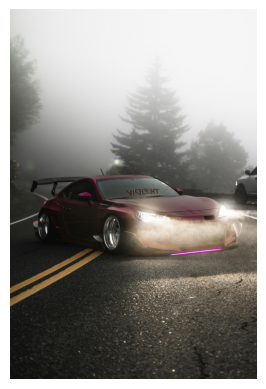

In [94]:
current_date = datetime.now().strftime("%Y%m%d")
file_name = GetFileNameWithoutExtension(imgPath)
output_dir_name = f"{file_name}_{current_date}"
# converter = CocoDataConverter(image_dir=f"./images_{output_dir_name}", output_dir=f"./output_{output_dir_name}")

# image
image = cv2.imread(imgPath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.ion()
plt.imshow(image)
plt.axis('off')
plt.show(block=False)
plt.pause(0.1)


# CLIP_predict
# status, result_dict = CLIP_predict(image)

# save_white_image
# class_label = result_dict["class_label"]
# prob = result_dict["prob"]
# result_str = f"{class_label}_{prob:.4f}"
# partial_file_name = f"{file_name}_{result_str}"
# converter.save_white_image(image, partial_file_name + ".png")

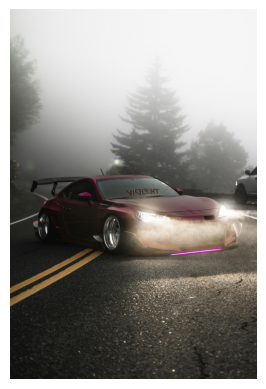

In [95]:
# mask_generator
torch.cuda.empty_cache()
masks2 = mask_generator_2.generate(image)
len(masks2) #0.9=174  #0.5=306 #0.1=307 #1=10

plt.imshow(image)
plt.axis('off')
plt.show(block=False)
plt.pause(0.1)

In [100]:
show_anns_white(masks2, image, area_threshold_min, area_threshold_max, file_name, output_dir_name)

Car: 0.38453
tire: 0.29947
people: 0.20582
Tree: 0.11017
